### Final Project

1. orientation
2. velocity

set body length to 1 unit, pool size about 1000x body size?

Notemigonus crysoleucas (golden shiner) and Gambusia holbrooki (mosquitofish)
cap the max velocity at like 50 cm/s so like 10 bodylength per seconds

visual latency is in the order of 10ms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
from matplotlib import colors

Initialization

In [32]:
N = 5 #number of fish
poolsize = 30 #relative to body length, maybe 1000
maxvelocity = 10 #bodylength per seconds

#init coordinations
motcoords = [(rng.randint(0,poolsize),rng.randint(0,poolsize)) for i in np.arange(N)]
xcoords, ycoords = zip(*motcoords)

#init orientations
motangles = [rng.randint(0,360) for i in np.arange(N)]
radmotangles = np.deg2rad(motangles)

#initialize velocity magnitude array
motvelmag = np.zeros(N)

#create a velocity (direction & magnitude) array
motvel = [(motvelmag[i]*np.cos(radmotangles[i]),motvelmag[i]*np.sin(radmotangles[i])) for i in np.arange(N)]
radmotangles

array([3.99680399, 6.09119909, 4.50294947, 5.48033385, 0.71558499])

Rule setting

In [38]:
#get distance to each neighbor
def finddistances(myindex, mycoord, coordarray):
    distances = [np.linalg.norm(np.subtract(mycoord, coordarray[i])) if i != myindex else np.nan for i in np.arange(len(coordarray))]
    return distances

#first find and index nearest neighbor
testcoord = (0,0)
coords = [(0,0), (1,0), (2,0), (0,3), (-4,3)]

def findnearestneighbor(myindex, mycoord, coordarray):
    dist = finddistances(myindex, mycoord, coordarray)
    neighbor_index = np.nanargmin(dist)
    return neighbor_index, dist


def findangletoneighbor(myorientation, mycoord, neighborcoord):
    correctionfornow = myorientation + np.pi/2
    myangle = correctionfornow #in radians
    myvector = (np.cos(myangle),np.sin(myangle))
    #get vector from me to you and normalize it
    vector_from_me_to_you = np.subtract(neighborcoord,mycoord)/np.linalg.norm(np.subtract(neighborcoord,mycoord))
    dotproduct = np.dot(myvector, vector_from_me_to_you)    
    return dotproduct




In [36]:
print(xcoords)
print(ycoords)
print(radmotangles)
print(motcoords)

(25, 7, 7, 25, 27)
(29, 23, 0, 23, 19)
[3.99680399 6.09119909 4.50294947 5.48033385 0.71558499]
[(25, 29), (7, 23), (7, 0), (25, 23), (27, 19)]


0.4914350783145812
nan
-0.981627183447664
0.19080899537654472
-0.005409315750099175


/var/folders/l9/3b20jgkd5w1dxc04tf2j0vgc0000gn/T/ipykernel_36787/2163361208.py:21: RuntimeWarning: invalid value encountered in divide
  vector_from_me_to_you = np.subtract(neighborcoord,mycoord)/np.linalg.norm(np.subtract(neighborcoord,mycoord))


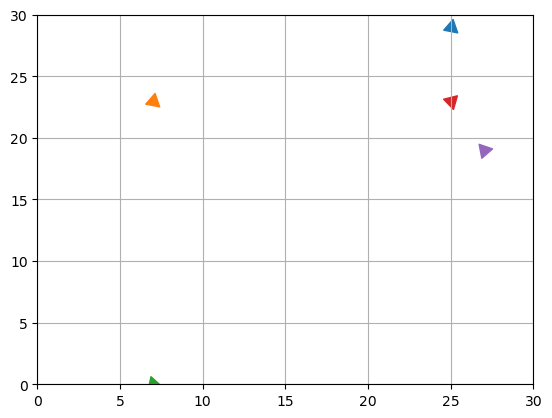

In [39]:
fig, ax = plt.subplots()
#scaling follows s = 125000/x^2 where x is the width of the coordinate

for i in np.arange(N):
    ax.scatter(xcoords[i],ycoords[i], marker = (3,0, motangles[i]), s = 125000/poolsize**2)

ax.set_xlim(0,poolsize)
ax.set_ylim(0,poolsize)
ax.grid()
plt.plot()

for i in np.arange(N):
    print(findangletoneighbor(radmotangles[1], motcoords[1], motcoords[i]))


In [31]:
#movement setting
#1. update acceleration (new velocity magnitude)
#2. update orientation
#3. update coordinate based on new velocity 
t = 0.01 #timestep doesn't have to be 1, since fish think faster than they move maybe this should be lower like 10-100 milliseconds
newmotcoords = [np.add(motcoords[i],np.array(motvel[i])*t) for i in np.arange(N)] # x = x+vt for all fish

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

- Radius of 1 body length = R 
- Speed: (front-back over side-side): This acceleration response was dependent on the fish’s current speed (multiply velocity by a factor)
- Attractive over R => accelerates/decelerates according to front or back
    - accelerate 1 bodylength based on the function cos(theta) where theta is the angle between the fish and its neighbor
- Maybe some weight over front than back
- Repulsive inside R => accelerates/decelerates according to front or back
- Turn: (relative angle over distance)
- Turn towards neighbor’s position (30-60º rotation depending on relative angle)


In [ ]:
#run this for all fish in one timestep

def updatespeed(nfish,positions,speeds, timestep, a = 0.5):
    t = timestep
    for i in np.arange(N):
        #first find the nearest neighbor
        neighindex, neighdist = findnearestneighbor(i, motcoords[i], motcoords)
        #Speed rule 1, attractve over R (2 body lengths) 
        if neighdist > 2:
            #update velocity magnitude based on where the other fish is. If in front, accelerate, if behind, deccelerate by a constant, let's say 0.5 bl/s^2
            motacc = a
            motvelmag[i] = motvelmag[i] + motacc*t
        #speed rule 2, repulsive under R
        elif neighdist < 2:
            motvelmag[i] = motvelmag[i] - motvelmag[i]*0.2

    
        



Plot

[]

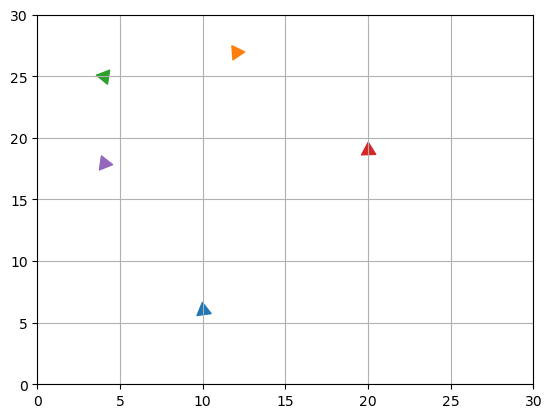

In [29]:
fig, ax = plt.subplots()
#scaling follows s = 125000/x^2 where x is the width of the coordinate

for i in np.arange(N):
    ax.scatter(xcoords[i],ycoords[i], marker = (3,0, motangles[i]), s = 125000/poolsize**2)

ax.set_xlim(0,poolsize)
ax.set_ylim(0,poolsize)
ax.grid()
plt.plot()


Analysis